In [1]:
import os
import tensorflow as tf
import numpy as np
from keras.models import Model,
from keras.layers import Input, Dense, Activation, BatchNormalization, Conv2D, SeparableConv2D, concatenate, MaxPooling2D, GlobalAveragePooling2D 
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import matplotlib.pyplot as plt
import h5py

%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\Xyrion\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


We load our CIFAR10 dataset directly from Keras.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

We check the shape of our data

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
keys = np.unique(y_test)
keys

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
values = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes = dict(zip(keys,values))
classes

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

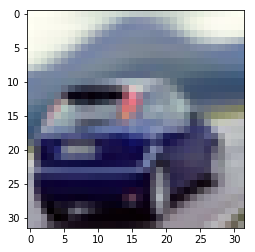

'automobile'

In [6]:
nb = np.random.choice(50000)
plt.imshow(x_train[nb], interpolation='nearest')
plt.show()
classes[y_train[nb][0]]

Normalization of the input data

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [5]:
def normalize(X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

In [6]:
x_train, x_test = normalize(x_train, x_test)

One hot vector encoding

In [10]:
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

We create the ddb_b block

In [11]:
def ddb_b(X_input, growth, repeat=6, **kwargs):
    X = X_input
    for i in range(repeat):
        X = Conv2D(growth, (1,1), strides = 1, **kwargs)(X_input)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        X = SeparableConv2D(growth, (3,3), strides=1, **kwargs)(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X_input = concatenate([X_input, X], axis = -1)
    return X_input

Model architecture

In [12]:
def tinyDSOD_backbone(input_shape, l2):
    regul = regularizers.l2(l2)
    kwargs = {'padding':'same', 'kernel_regularizer':regul,'kernel_initializer':'glorot_uniform'}

    ### STEM ###
    # Convolution 1
    inp = Input(input_shape)
    X = Conv2D(64, (3,3), strides=2, **kwargs)(inp)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Convolution 2
    X = Conv2D(64, (1,1), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Depth-wise seperable convolution 1
    X = SeparableConv2D(64, (3,3), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Convolution 3
    X = Conv2D(128, (1,1), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Depth-wise seperable convolution 2
    X = SeparableConv2D(128, (3,3), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Pooling
    X = MaxPooling2D((2,2), strides=2, padding='same')(X)
    
    ### Extractor ###
    # Dense stage 0
    X = ddb_b(X, 32, repeat=4, **kwargs)
    
    # Transition layer 0
    X = Conv2D(128, (1,1), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), strides=2, padding='same')(X)
    
    # Dense stage 1
    X = ddb_b(X, 48, repeat = 6, **kwargs)
    
    # Transition layer 1
    X = Conv2D(128, (1,1), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), strides=2, padding='same')(X)
    
    # Dense stage 2
    X = ddb_b(X, 64, repeat=6, **kwargs)
    
    # Transition layer 2
    X = Conv2D(256, (1,1), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Dense stage 3
    X = ddb_b(X, 80, repeat=6, **kwargs)
    
    # Transition layer 3
    X = Conv2D(64, (1,1), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    
    ### Classification layers ###
    X = GlobalAveragePooling2D()(X)
    X = Dense(10, activation='softmax', kernel_regularizer=regul, kernel_initializer='glorot_uniform')(X)
    
    ### Create Model ### 
    
    model = Model(inputs=inp, outputs=X, name='TinyDSOD_bb')
    
    return model

In [21]:
classification_model = tinyDSOD_backbone((32,32,3), l2=5e-4)

In [14]:
classification_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [15]:
 datagen = ImageDataGenerator(
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images

datagen.fit(x_train)

In [37]:
learning_rate = 0.1
lr_drop = 20

#We create a checkpoint to save the best model and add an early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=60, verbose=1, mode='min')
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = LearningRateScheduler(lr_scheduler)
callbacks_list = [early_stop, reduce_lr]
    

print(model_name)
    
sgd = SGD(lr=learning_rate, momentum=0.9, decay=1e-6, nesterov=True)
classification_model.compile(optimizer = sgd, loss = "categorical_crossentropy", metrics=['accuracy'])

classification_model.fit_generator(
                        datagen.flow(x_train, y_train, batch_size=128),
                        epochs=300,
                        validation_data=(x_test, y_test),
                        workers=4,
                        shuffle = True,
                        callbacks=callbacks_list)

MODEL.h5
Epoch 1/300
391/391 [==============================] - 64s 164ms/step - loss: 2.8208 - acc: 0.4359 - val_loss: 2.5351 - val_acc: 0.4325
Epoch 2/300
391/391 [==============================] - 37s 94ms/step - loss: 1.8887 - acc: 0.5795 - val_loss: 2.0169 - val_acc: 0.5279
Epoch 3/300
391/391 [==============================] - 38s 96ms/step - loss: 1.5068 - acc: 0.6316 - val_loss: 1.5165 - val_acc: 0.6109
Epoch 4/300
391/391 [==============================] - 37s 95ms/step - loss: 1.3179 - acc: 0.6588 - val_loss: 1.4858 - val_acc: 0.6007
Epoch 5/300
391/391 [==============================] - 38s 96ms/step - loss: 1.2052 - acc: 0.6905 - val_loss: 1.2353 - val_acc: 0.6851
Epoch 6/300
391/391 [==============================] - 37s 96ms/step - loss: 1.1382 - acc: 0.7108 - val_loss: 1.2457 - val_acc: 0.6818
Epoch 7/300
391/391 [==============================] - 37s 95ms/step - loss: 1.0888 - acc: 0.7306 - val_loss: 2.4875 - val_acc: 0.4352
Epoch 8/300
391/391 [========================

391/391 [==============================] - 46s 117ms/step - loss: 0.1972 - acc: 0.9772 - val_loss: 0.5164 - val_acc: 0.8980
Epoch 122/300
391/391 [==============================] - 45s 114ms/step - loss: 0.1870 - acc: 0.9815 - val_loss: 0.5216 - val_acc: 0.8932
Epoch 123/300
391/391 [==============================] - 45s 115ms/step - loss: 0.1822 - acc: 0.9830 - val_loss: 0.5299 - val_acc: 0.8940
Epoch 124/300
391/391 [==============================] - 44s 113ms/step - loss: 0.1806 - acc: 0.9831 - val_loss: 0.5107 - val_acc: 0.8990
Epoch 125/300
391/391 [==============================] - 45s 115ms/step - loss: 0.1745 - acc: 0.9848 - val_loss: 0.5135 - val_acc: 0.8981
Epoch 126/300
391/391 [==============================] - 44s 113ms/step - loss: 0.1750 - acc: 0.9842 - val_loss: 0.5229 - val_acc: 0.8965
Epoch 127/300
391/391 [==============================] - 43s 110ms/step - loss: 0.1716 - acc: 0.9851 - val_loss: 0.5377 - val_acc: 0.8921
Epoch 128/300
391/391 [=========================

In [23]:
classification_model.save_weights('cifar10_dsodtiny_bb.h5')

We reach an overall accuracy of 90%. Moreover the models seems to be overfitting, we should be able to reach a slightly better accurracy with more regularization and longer training.

We can compare this accuracy with other more classical models with a similar training time:
https://github.com/kuangliu/pytorch-cifar

We observe that our accuracy is closed to some popular like vgg16 (92,64%) or resnet50 (93,62%), while having a much lower number of parameters (136 millions for vgg16) and (26millions for ResNet50)
